Image classification notebook

Import packages

In [1]:
from skimage import io
import torch
from torchvision import models
import torchvision
import torch.nn as nn
import numpy as np
import random
from IPython.display import clear_output
import time
import os.path
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split

Define image loader

In [2]:
def iloader(path):
  image = np.asarray((io.imread(path))/32000, dtype='float32')
  return image.transpose(2, 0, 1)

Loading the data

In [14]:
def load_data():
    data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'jpg')
    train_set, val_set = train_test_split(data, test_size=0.2, stratify=data.targets)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=3, drop_last = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0, drop_last = True)
    return train_loader, val_loader #,test_loader

Download the data

In [15]:
data_folder = '/content/sample_data/'
root = '2750/'
down_where = os.path.exists(root)
if not down_where:
  os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip')
  !unzip EuroSAT.zip
  down_where = True

Augmentation

In [16]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def custom_aug(data):
  data = torch.rot90(data,random.randint(-3,3), dims=random.choice([[3,2],[2,3]]))
  if random.random()>0.75:
    data = torch.flip(data, dims = random.choice([[2,],[3,],[2,3]]))
  pixmis = torch.empty_like(data).random_(data.shape[-1])
  pixmis = torch.where(pixmis>(data.shape[-1]/8),torch.ones_like(data),torch.zeros_like(data))
  return data* pixmis

Load the network model

In [17]:
def Load_model():
  model_ft = models.resnet50()
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 10)
  inBands = 3
  model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
  print('Model Loaded')
  return model_ft


Calculate the accuracy

In [18]:
def accuracy(gt_S,pred_S):
  _, alp = torch.max(torch.from_numpy(pred_S), 1)
  return accuracy_score(gt_S,np.asarray(alp))

Test

In [19]:
def validation(model, test_,):
    model.eval()
    #tot_acc=[]
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_):
            data, target = custom_aug(Variable(data.cuda())), Variable(target.cuda())
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
        acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc#,cm

Train the network

In [20]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10):
    losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    iter_ = t0 =0
    for e in range(1, epochs + 1):
        net.train()
        for batch_idx, (data, target) in enumerate(train_):
            data, target =  custom_aug(Variable(data.cuda())), Variable(target.cuda()),
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses,loss.item())
            mean_losses = np.append(mean_losses, np.mean(losses[max(0,iter_-100):iter_]))
            if iter_ % 600 == 0: #printing after 600 epochs
                clear_output()
                print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
                t0 = time.time()
                pred = output.data.cpu().numpy()#[0]
                pred=sigmoid(pred)
                gt = target.data.cpu().numpy()#[0]
                acc = np.append(acc,accuracy(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses) and plt.show()
                val_acc = np.append(val_acc,validation(net, val_))
                print('validation accuracy : {}'.format(val_acc[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
                #print(mylabels[np.where(gt[1,:])[0]])
            iter_ += 1

            del(data, target, loss)
        if scheduler is not None:
           scheduler.step()
        if e % save_epoch == 0:

            torch.save(net.state_dict(), '.\Eurosat{}'.format(e))
    return net

Calling function

Iteration Number 6600 27.248528957366943 seconds
Train (epoch 5/5) [1200/1350 (89%)]	Loss: 0.711380	Accuracy: 0.875	Learning Rate:0.01


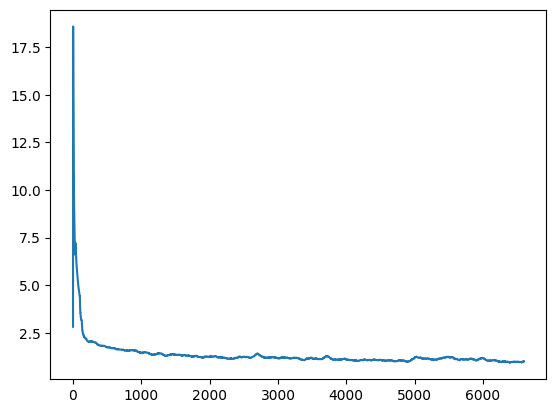

validation accuracy : 0.6005192878338279


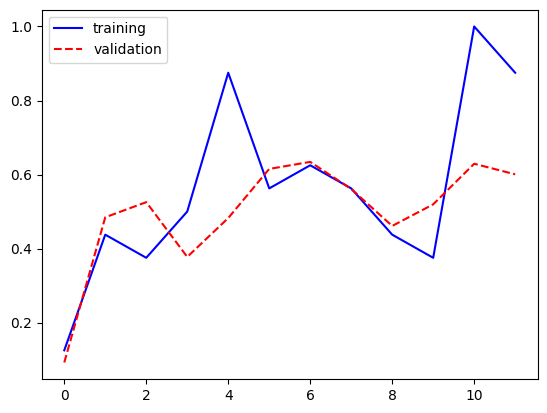

Test Accuracy: 0.6294510385756676


In [21]:
lr = 0.01
milestones = [50, 75, 90]
epochs = 5

if __name__ == '__main__':
	torch.manual_seed(0)
	np.random.seed(0)
	torch.cuda.manual_seed(0)
	random.seed(0)
	print("pytorch version", torch.__version__)
	criteria = torch.nn.CrossEntropyLoss()
	net = Load_model()
	train_loader, val_loader =load_data()
	net=net.cuda()
	optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
	scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
	net = train(net, train_loader, val_loader, criteria, optimizer, epochs, scheduler)
	test_accuracy = validation(net, val_loader)
	print('Test Accuracy: {}'.format(test_accuracy))
